#Representacion de Infeccion por COVID
A continuacion se representara la infeccion causada por la enfermedad conocida como la COVID-19, causa por el virus SARS-COV2 el cual causo una pandemia la cual inicio a principios de 2020 y aun sigue afectando a millones de personas. Esta representacion se hara usando agentes los cuales representaran a personas vivas no infectadas, personas vivas infectas y personas difuntas.

Se usaran los siguientes color para representar a los diferentes agentes

**Verde** = Personas Vivas No Infectadas

**Azul** = Personas Vivas Infectadas

**Rojo** = Personas Difuntas

#Reglas

Las Reglas que se usaran dentro del modelo de representacion de infeccion de COVID-19 son las siguientes


*   1/3 de los agentes estara inicialmente infectados
*   2/3 de los agentes estaran saludables
*   Si un agente saludable tiene como vecino 4 agentos o mas infectados este sera infectado
*   Si un agente es infectado este tendra una probabilidad de 1/10 de convertirse en un agente difunto





In [1]:
!python3 -m pip install mesa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 4.6 MB/s eta 0:00:00


## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes. 

In [2]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model 

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
import random

In [3]:
old_cmap = mlp.cm.get_cmap('viridis', 3)
colors = old_cmap(np.linspace(0, 1, 3))

colors[2] = np.array([256/256, 0/256, 0/256, 1]) # Red
colors[1] = np.array([0/256, 256/256, 0/256, 1]) # Green
colors[0] = np.array([86/256, 102/256, 255/256, 1]) # Blue

colormap = mlp.colors.ListedColormap(colors)

## Crear el modelo

Antes que nada el presente modelo se encuentra basado en el [tutorial introductorio](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html). Se modificó para que funcionara con el presente problema pero en esencia es lo mismo.

In [4]:
class GameLifeAgent(Agent):
    """
    Representa a un agente o una celda con estado vivo (1) o muerto (0)
    """
    def __init__(self, unique_id, model):
        """
        Crea un agente con estado inicial aleatorio de 0 ó 1, también se le asigna un identificador
        formado por una tupla (x,y). Se define un nuevo estado cuyo valor será definido por las
        reglas mencionadas arriba.
        """
        super().__init__(unique_id, model)
        self.live = np.random.choice([1,1,0])
        self.next_state = None
    
    def step(self):

      neighbours = self.model.grid.get_neighbors(
      self.pos,
      moore=True,
      include_center=False)

      live_neighbours = 0
      infected_neighbours = 0

      for neighbor in neighbours:
        if neighbor.live == 1:
          live_neighbours+=1
        if neighbor.live == 0:
          infected_neighbours+=1

      self.next_state=self.live
      
      if self.next_state==1:
        if infected_neighbours >= 4:
          self.next_state = 0
          if random.random() < 0.1:
            self.next_state=2



    def advance(self):
        """
        Define el nuevo estado calculado del método step.
        """
        self.live = self.next_state
            
class GameLifeModel(Model):
    """
    Define el modelo del juego de la vida.
    """
    def __init__(self, width, height):
        self.width = width
        self.height = height

        self.reset()

    def reset(self):
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True)
        self.schedule = SimultaneousActivation(self)

        for (content, x, y) in self.grid.coord_iter():
            a = GameLifeAgent((x, y), self)
            self.grid.place_agent(a, (x, y))
            self.schedule.add(a)

        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid,
                             "Live": self.get_live,
                             "Death": self.get_death,
                             "Infected": self.get_infected}
        )
    
    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            grid[x][y] = cell_content.live

        return grid

    def get_live(self):
        total_live_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, x, y = cell
            if isinstance(agent, GameLifeAgent):
                total_live_agents += agent.live
        return total_live_agents

    def get_death(self):
      total_death_agents = 0
      for cell in model.grid.coord_iter():
            agent, x, y = cell
            if isinstance(agent, GameLifeAgent):
              if agent.live ==2:
                total_death_agents += 1
      return total_death_agents

    def get_infected(self):
      total_infected_agents = 0
      for cell in model.grid.coord_iter():
            agent, x, y = cell
            if isinstance(agent, GameLifeAgent):
              if agent.live ==0:
                total_infected_agents += 1
      return total_infected_agents


# Ejecución del modelo
A continuación corremos el modelo

In [5]:
# Definimos el tamaño del Grid ..> 7 x 7
GRID_SIZE = 100

# Definimos el número de generaciones a correr
NUM_GENERATIONS = 50

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()

model = GameLifeModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_GENERATIONS):
    model.step()
final_time = time.time()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:00:24.673429


In [6]:
# Definimos el tamaño del Grid ..> 7 x 7
GRID_SIZE = 100

# Definimos el número de generaciones a correr
NUM_GENERATIONS = 100

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()

model = GameLifeModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_GENERATIONS):
    model.step()
final_time = time.time()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:00:16.830880


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [7]:
all_grids = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [8]:
all_grids

,Grid,Live,Death,Infected
0,"[[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0,...",6673,0,3327
1,"[[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",5325,184,4859
2,"[[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",4162,331,6169
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3249,444,7195
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2622,531,7909
...,...,...,...,...
95,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1322,661,9339
96,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1322,661,9339
97,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1322,661,9339
98,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1322,661,9339


In [9]:
%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

patch_grid = axs.imshow(model.get_grid(), cmap=colormap)

cells_alive = []
cells_death = []
cells_infected = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])
    cells_alive.append(all_grids['Live'].iloc[i])
    cells_death.append(all_grids['Death'].iloc[i])
    cells_infected.append(all_grids['Infected'].iloc[i])
    

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [10]:
anim

#Grafica 1
Verde = Personas Vivas No Infectas 

Rojo = Personas Muertas

Azul = Personas Infectadas

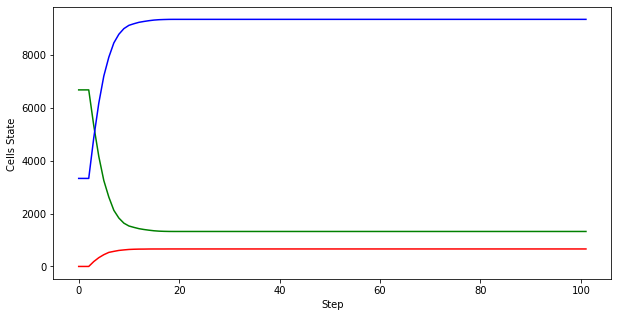

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Cells State ")

plt.plot(cells_alive, color='Green')
plt.plot(cells_death,color='Red')
plt.plot(cells_infected, color='Blue')
plt.show()

La siguiente grafica representa el numero de infectas, personas vivas pero no infectadas y personas que murieron a causa de la enfermedad.

Podemos observar como el numero de personas infectadas se incremente de manera exponencial hasta llegar a un punto donde no se pueden infectar mas personas, al mismo tiempo que esto sucede el numero de personas vivas pero no infectas baja de manera exponencial, comportandose asi de manera contraria a la del numero de personas infectas, al igual podemos ver como el numero de personas muertas se incrementa sin embargo no con la misma magnitud.


In [12]:
import random
random.sample([1, 2, 3, 5], k=2)

[1, 3]

# Batch simulation

In [13]:
NUM_REPS = 100
GRID_SIZE = 10
NUM_GENERATIONS = 1000

model = GameLifeModel(GRID_SIZE, GRID_SIZE)

batch_data = dict(time=[], alive=[],dead=[],infected=[])
for _ in range(NUM_REPS):
    start_time = time.time()

    model.reset()
    for i in range(NUM_GENERATIONS):
        model.step()
    final_time = time.time()

    all_grids = model.datacollector.get_model_vars_dataframe()

    batch_data['time'].append(final_time - start_time)
    batch_data['alive'].append(all_grids['Live'].to_numpy())
    batch_data['dead'].append(all_grids['Death'].to_numpy())
    batch_data['infected'].append(all_grids['Infected'].to_numpy())


#Grafica 2(Simulacion Batch)
Verde = Personas Vivas No Infectas 

Rojo = Personas Muertas

Azul = Personas Infectadas

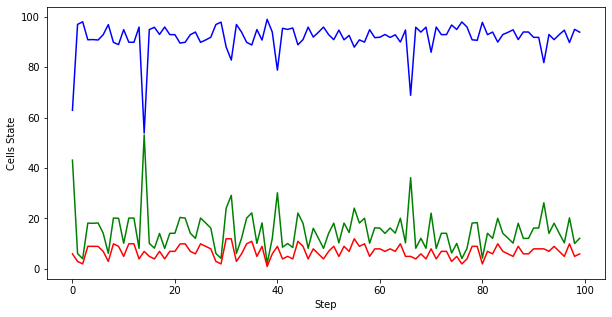

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Cells State")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))


plt.plot(np.average(np.array(batch_data['alive']), axis=1), color='Green')
plt.plot(np.average(np.array(batch_data['dead']), axis=1), color='Red')
plt.plot(np.average(np.array(batch_data['infected']), axis=1), color='Blue')

plt.show()